In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

def loadData():
    json_path = os.path.join(os.getcwd(), "..", "ds2_dense", "ds2_dense", "deepscores_train.json")
    with open(json_path, "r") as f:
        data = json.load(f)
    return data

def extractAnnotations(data):
    df = pd.DataFrame(data["annotations"]).transpose()
    width  = df["a_bbox"].str[2] - df["a_bbox"].str[0]
    height = df["a_bbox"].str[3] - df["a_bbox"].str[1]
    anns = df[(width!=0)&(height!=0)].copy()
    anns["cat_id"] = anns["cat_id"].str[0]
    anns["img_id"]  = pd.to_numeric(anns["img_id"])
    return anns.drop(columns=["o_bbox","area","comments"])

def compute_grid_counts(df, img_id, grid_size, img_size):
    gx, gy       = grid_size
    img_w, img_h = img_size
    sub = df[df["img_id"] == img_id]   # assume same dtype
    counts = np.empty((gy, gx), dtype=object)
    for j in range(gy):
        for i in range(gx):
            counts[j,i] = []
    for row_idx, bbox in sub["a_bbox"].items():
        x0,y0,x1,y1 = map(int, bbox)
        xc, yc = (x0+x1)/2, (y0+y1)/2
        i = min(int(xc/img_w*gx), gx-1)
        j = min(int(yc/img_h*gy), gy-1)
        counts[j,i].append(row_idx)
    return counts

def sorted_cells_by_count(counts):
    gy, gx = counts.shape
    flat = counts.ravel()
    lengths = np.fromiter((len(c) for c in flat), dtype=int)
    idx_desc = np.argsort(lengths)[::-1]
    return [((idx//gx, idx%gx), int(lengths[idx])) for idx in idx_desc]

def maxBoxes(img_id):
    counts     = compute_grid_counts(anns, img_id, (112,112),
                                     (img_df.loc[img_id,"width"],
                                      img_df.loc[img_id,"height"]))
    busy = sorted_cells_by_count(counts)[:10]
    return busy





In [5]:
import util
de = util.DataExtractor()
data = de.loadData()
anns = extractAnnotations(data)
img_df = pd.DataFrame(data["images"]).set_index("id")

Saving to: c:\Users\alexh\Desktop\ComputerVision\Hausarbeit\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [ ]:
def peak_cell_count(img_id, grid=(112,112)):
    w = img_df.at[img_id, "width"]
    h = img_df.at[img_id, "height"]
    counts = compute_grid_counts(anns, img_id, grid, (w, h))
    return max(len(c) for c in counts.ravel())




zeros: 0 of 1362


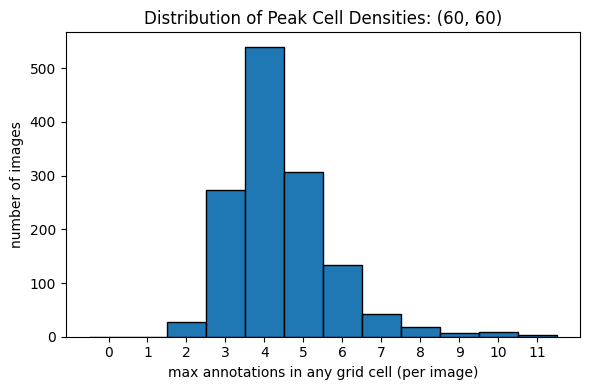

min/median/95%/max: 2 4.0 7.0 11
zeros: 0 of 1362


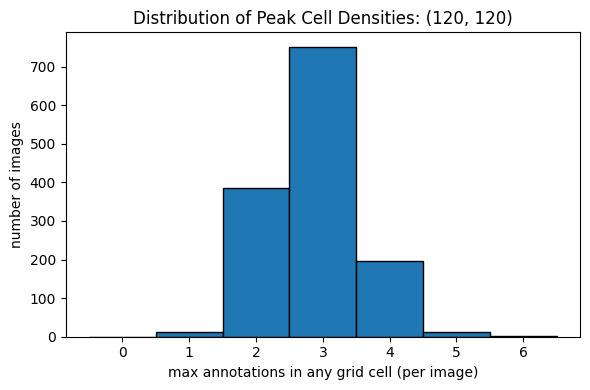

min/median/95%/max: 1 3.0 4.0 6
zeros: 0 of 1362


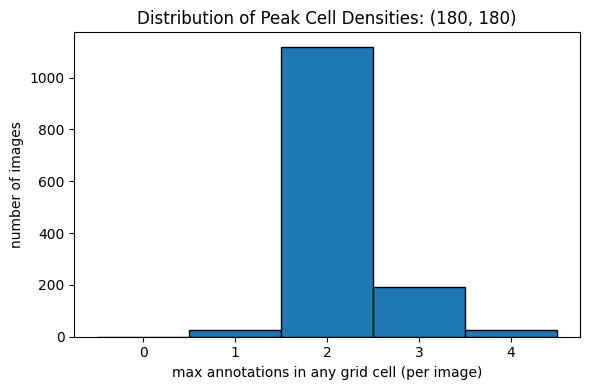

min/median/95%/max: 1 2.0 3.0 4


In [9]:

grids = [(60, 60), (120, 120), (180,180)]
for grid in grids:
      peaks = [peak_cell_count(i, grid = grid) for i in anns["img_id"].unique()]

      # quick sanity: how often is the max 0? (should be 0 if anns/imgs align)
      print("zeros:", sum(1 for p in peaks if p == 0), "of", len(peaks))

      # --- histogram of max annotations per cell per image ---
      plt.figure(figsize=(6,4))
      plt.hist(peaks, bins=range(max(peaks)+2), align='left', edgecolor='black')
      plt.title(f"Distribution of Peak Cell Densities: {grid}")
      plt.xlabel("max annotations in any grid cell (per image)")
      plt.ylabel("number of images")
      plt.xticks(range(max(peaks)+1))
      plt.tight_layout()
      plt.show()

      # optional quick stats
      print("min/median/95%/max:", np.min(peaks), np.median(peaks),
            np.percentile(peaks,95), np.max(peaks))

total anns in df: 889455
from 60x60 hist  : 889455
from 120x120 hist: 889455
from 180x180 hist: 889455


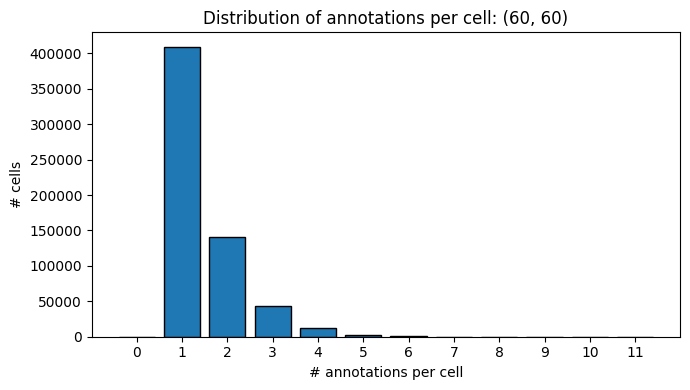

cells: 608841 | zero-cells: 0 (0.0%) | mean/cell: 1.4608986582703858


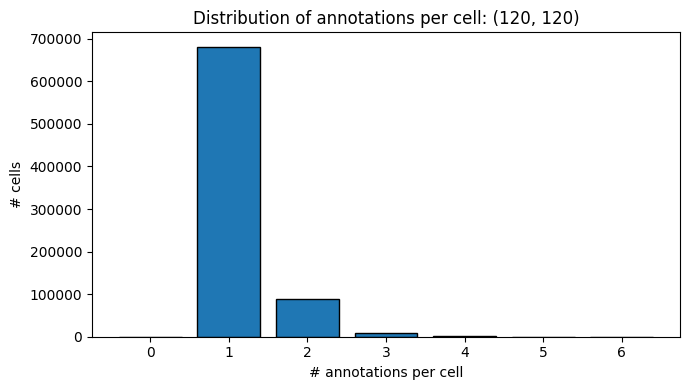

cells: 779405 | zero-cells: 0 (0.0%) | mean/cell: 1.1411974519024128


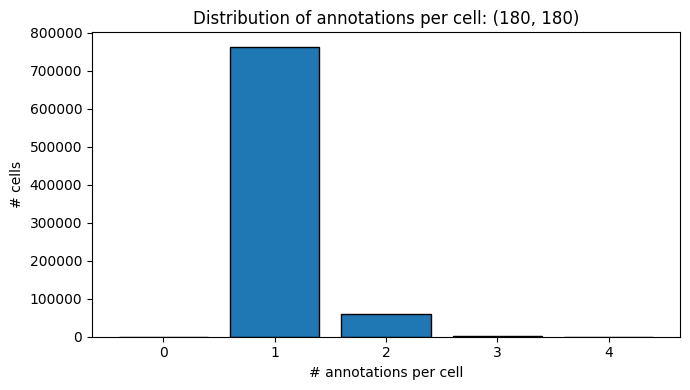

cells: 825712 | zero-cells: 0 (0.0%) | mean/cell: 1.0771976185401204


In [21]:
from collections import Counter

def per_cell_count_hist(grid=(112,112), include_all_images=True, exclude_zeros=True):
    gx, gy = grid
    hist = Counter()
    img_ids = (img_df.index if include_all_images else
               anns["img_id"].unique())

    for img_id in img_ids:
        w = img_df.at[img_id, "width"]; h = img_df.at[img_id, "height"]
        sub = anns[anns["img_id"] == img_id]

        if len(sub):
            a = np.stack(sub["a_bbox"].values)  # (N,4)
            xc = (a[:,0] + a[:,2]) * 0.5
            yc = (a[:,1] + a[:,3]) * 0.5
            i = np.clip((xc / w * gx).astype(int), 0, gx-1)
            j = np.clip((yc / h * gy).astype(int), 0, gy-1)
            k = j * gx + i
            counts = np.bincount(k, minlength=gx*gy)
        else:
            counts = np.zeros(gx*gy, dtype=int)

        if exclude_zeros:
            counts = counts[counts > 0]

        hist.update(counts.tolist())
    

    return hist

# build and plot
hist = per_cell_count_hist(grid=(240,240), include_all_images=False)
hist = per_cell_count_hist(grid=(60,60), include_all_images=False)

def total_from_hist(hist):  # works with or without zeros
    return sum(k * v for k, v in hist.items())

h60  = per_cell_count_hist(grid=(60,60),  include_all_images=True,  exclude_zeros=True)
h120 = per_cell_count_hist(grid=(120,120), include_all_images=True,  exclude_zeros=True)
h180 = per_cell_count_hist(grid=(180 ,180), include_all_images=True,  exclude_zeros=True)
print("total anns in df:", len(anns))
print("from 60x60 hist  :", total_from_hist(h60))
print("from 120x120 hist:", total_from_hist(h120))
print("from 180x180 hist:", total_from_hist(h180))

histograms = [(h60, (60, 60)), (h120, (120, 120)), (h180, (180, 180))]
for (hist, grid) in histograms:

    xs = np.arange(max(hist) + 1)
    ys = np.array([hist.get(x, 0) for x in xs])

    plt.figure(figsize=(7,4))
    plt.bar(xs, ys, edgecolor='black')
    plt.title(f"Distribution of annotations per cell: {grid}")
    plt.xlabel("# annotations per cell")
    plt.ylabel("# cells")
    plt.xticks(xs if len(xs) <= 50 else np.arange(0, xs[-1]+1, max(1, xs[-1]//20)))
    plt.tight_layout(); plt.show()

    # quick sanity stats
    total_cells = ys.sum()
    print("cells:", total_cells,
        "| zero-cells:", hist.get(0,0),
        f"({hist.get(0,0)/total_cells:.1%})",
        "| mean/cell:", np.average(xs, weights=ys))
